<a href="https://colab.research.google.com/github/sparsh-ai/reco-book/blob/stage/nbs/T057885_Offline_Replayer_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline Replayer Evaluation

## Recogym
> Running recogym for offline simulation and evaluation

In [ ]:
!pip install -q recogym

In [ ]:
import numpy as np
from numpy.random.mtrand import RandomState
from scipy.special import logsumexp
import scipy
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from itertools import chain
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, HTML

from matplotlib.ticker import FormatStrFormatter

import gym, recogym
from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents.organic_count import OrganicCount, organic_count_args, to_categorical
from recogym import Configuration
from recogym.agents import Agent
from recogym.envs.observation import Observation
from recogym.agents import RandomAgent, random_args
from recogym import verify_agents, verify_agents_IPS
from recogym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k

from recogym.envs.session import OrganicSessions
from recogym.envs.context import DefaultContext
from recogym.envs.observation import Observation

import matplotlib.pyplot as plt
%matplotlib inline

P = 2000 # Number of Products
U = 2000 # Number of Users

In [ ]:
# You can overwrite environment arguments here
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P//2
env_1_args['sigma_mu_organic'] = 0.1
env_1_args['sigma_omega']=0.05

In [ ]:
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [ ]:
# env.reset()

In [ ]:
# Generate RecSys logs for U users
reco_log = env.generate_logs(U)
reco_log.head(20)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 2000/2000 [02:15<00:00, 14.73it/s]


,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,116,<NA>,NaN,NaN,None
1,1.0,0,bandit,<NA>,1123,0.0,0.0005,()
2,2.0,0,bandit,<NA>,1332,0.0,0.0005,()
3,3.0,0,bandit,<NA>,805,0.0,0.0005,()
4,4.0,0,bandit,<NA>,1184,0.0,0.0005,()
5,0.0,1,organic,1205,<NA>,NaN,NaN,None
6,1.0,1,organic,1137,<NA>,NaN,NaN,None
7,2.0,1,organic,1337,<NA>,NaN,NaN,None
8,3.0,1,organic,972,<NA>,NaN,NaN,None
9,4.0,1,organic,841,<NA>,NaN,NaN,None


In [ ]:
n_events = reco_log.shape[0]
n_organic = reco_log.loc[reco_log['z'] == 'organic'].shape[0]
print('Training on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Training on 43753 organic and 159967 bandit events


### Defining evaluation methods

#### Traditional evaluation

In [ ]:
def leave_one_out(reco_log, agent, last = False, N = 1, folds = 10):
    # 1. Extract all organic events
    reco_log = reco_log.loc[reco_log['z'] == 'organic']
    
    # 2. For every user sequence - randomly sample out an item
    hits = []
    for _ in range(folds):
        user_id = 0
        history = []
        session = OrganicSessions()
        agent.reset()
        for row in reco_log.itertuples():
            # If we have a new user
            if row.u != user_id:
                if last:
                    # Sample out last item
                    index = len(history) - 1
                else:
                    # Sample out a random item from the history
                    index = np.random.choice(len(history),
                                             replace = False)
                test  = history[index]
                train = history[:index] + history[index + 1:]

                # 3. Recreate the user sequence without these items - Let the agent observe the incomplete sequence
                for t, v in list(train):
                    session.next(DefaultContext(t, user_id), int(v))

                # 4. Generate a top-N set of recommendations by letting the agent act
                # TODO - For now only works for N = 1
                try:
                    prob_a = agent.act(Observation(DefaultContext(t + 1, user_id), session), 0, False)['ps-a']
                except:
                    prob_a = [1 / P] * P

                # 5. Compute metrics checking whether the sampled test item is in the top-N
                try:
                  hits.append(np.argmax(prob_a) == int(test[1]))
                except:
                  hits.append(0)

                # Reset variables
                user_id = row.u
                history = []
                session = OrganicSessions()
                agent.reset()

            # Save the organic interaction to the running average for the session
            history.append((row.t,row.v))
    
    # Error analysis
    mean_hits = np.mean(hits)
    serr_hits = np.std(hits) / np.sqrt(len(hits))
    low_bound = mean_hits - 1.96 * serr_hits
    upp_bound = mean_hits + 1.96 * serr_hits
    
    return mean_hits, low_bound, upp_bound

def verify_agents_traditional(reco_log, agents, last = False, N = 1, folds = 10):
    # Placeholder DataFrame for result
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Compute HR@k
        mean, low, upp = leave_one_out(reco_log, agents[agent_id], last = last, N = N, folds = folds)
        stat['Agent'].append(agent_id)
        stat['0.025'].append(low)
        stat['0.500'].append(mean)
        stat['0.975'].append(upp)
    return pd.DataFrame().from_dict(stat)

#### Counterfactual evaluation

In [ ]:
def compute_ips_weights(agent, reco_log):
    # Placeholder for return values
    rewards = [] # Labels for actions
    t_props = [] # Treatment propensities
    l_props = [] # Logging propensities
    
    # For every logged interaction
    user_id = 0
    session = OrganicSessions()
    agent.reset()
    for row in reco_log.itertuples():
        # If we have a new user
        if row.u != user_id:
            # Reset
            session = OrganicSessions()
            agent.reset()
            user_id = row.u
        
        # If we have an organic event
        if row.z == 'organic':
            session.next(DefaultContext(row.t, row.u), int(row.v))        
            
        else:
            prob_a = agent.act(Observation(DefaultContext(row.t, row.u), session), 0, False)['ps-a']
            rewards.append(row.c)
            try:
              t_props.append(prob_a[int(row.a)])
            except:
              t_props.append(0)
            l_props.append(row.ps)
            session = OrganicSessions()
    
    return np.asarray(rewards), np.asarray(t_props), np.asarray(l_props)

def verify_agents_counterfactual(reco_log, agents, cap = 3):
    # Placeholder DataFrame for results
    IPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    CIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    SNIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Get the rewards and propensities
        rewards, t_props, l_props = compute_ips_weights(agents[agent_id], reco_log)
        
        # Compute the sample weights - propensity ratios
        p_ratio = t_props / l_props

        # Effective sample size for E_t estimate (from A. Owen)
        n_e = len(rewards) * (np.mean(p_ratio) ** 2) / (p_ratio ** 2).mean()
        n_e = 0 if np.isnan(n_e) else n_e
        print("Effective sample size for agent {} is {}".format(str(agent_id), n_e))
        
        # Critical value from t-distribution as we have unknown variance
        alpha = .00125
        cv = scipy.stats.t.ppf(1 - alpha, df = int(n_e) - 1)
        
        ###############
        # VANILLA IPS #
        ###############
        # Expected reward for pi_t
        E_t = np.mean(rewards * p_ratio)

        # Variance of the estimate
        var = ((rewards * p_ratio - E_t) ** 2).mean()
        stddev = np.sqrt(var)
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound = E_t - cv * stddev / np.sqrt(int(n_e))
        max_bound = E_t + cv * stddev / np.sqrt(int(n_e))
        
        # Store result
        IPS_stat['Agent'].append(agent_id)
        IPS_stat['0.025'].append(min_bound)
        IPS_stat['0.500'].append(E_t)
        IPS_stat['0.975'].append(max_bound)
        
        ############### 
        # CAPPED IPS #
        ##############
        # Cap ratios
        p_ratio_capped = np.clip(p_ratio, a_min = None, a_max = cap)
        
        # Expected reward for pi_t
        E_t_capped = np.mean(rewards * p_ratio_capped)

        # Variance of the estimate
        var_capped = ((rewards * p_ratio_capped - E_t_capped) ** 2).mean()
        stddev_capped = np.sqrt(var_capped)        
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_capped = E_t_capped - cv * stddev_capped / np.sqrt(int(n_e))
        max_bound_capped = E_t_capped + cv * stddev_capped / np.sqrt(int(n_e))
        
        # Store result
        CIPS_stat['Agent'].append(agent_id)
        CIPS_stat['0.025'].append(min_bound_capped)
        CIPS_stat['0.500'].append(E_t_capped)
        CIPS_stat['0.975'].append(max_bound_capped)
        
        ##############
        # NORMED IPS #
        ##############
        # Expected reward for pi_t
        E_t_normed = np.sum(rewards * p_ratio) / np.sum(p_ratio)

        # Variance of the estimate
        var_normed = np.sum(((rewards - E_t_normed) ** 2) * (p_ratio ** 2)) / (p_ratio.sum() ** 2)    
        stddev_normed = np.sqrt(var_normed)

        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_normed = E_t_normed - cv * stddev_normed / np.sqrt(int(n_e))
        max_bound_normed = E_t_normed + cv * stddev_normed / np.sqrt(int(n_e))

        # Store result
        SNIPS_stat['Agent'].append(agent_id)
        SNIPS_stat['0.025'].append(min_bound_normed)
        SNIPS_stat['0.500'].append(E_t_normed)
        SNIPS_stat['0.975'].append(max_bound_normed)
        
    return pd.DataFrame().from_dict(IPS_stat), pd.DataFrame().from_dict(CIPS_stat), pd.DataFrame().from_dict(SNIPS_stat)

### Creating agents

#### SVD agent

In [ ]:
class SVDAgent(Agent):
    def __init__(self, config, U = U, P = P, K = 5):
        super(SVDAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        assert(P >= K)
        self.K = K
        self.R = csr_matrix((U,P))
        self.V = np.zeros((P,K))
        self.user_history = np.zeros(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Singular Value Decomposition
        _, _, self.V = svds(self.R, k = self.K)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.V.T).dot(self.V)
        action = np.argmax(scores)
        prob = np.zeros_like(scores)
        prob[action] = 1.0

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

#### Item-KNN agent

In [ ]:
class itemkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(itemkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.Rt = csr_matrix((P,U))
        self.user_history = np.zeros(P)
        self.S = np.eye(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R_t = csr_matrix((np.ones(len(reco_log)),
                              (reco_log['v'],reco_log['u'])),
                              (P,U))

        # Set up nearest neighbours module
        nn = NearestNeighbors(n_neighbors = self.k,
                              metric = 'cosine')

        # Initialise placeholder for distances and indices
        distances = []
        indices   = []

        # Dirty fix for multiprocessing backend being unable to pickle large objects
        nn.fit(self.R_t)
        distances, indices = nn.kneighbors(self.R_t, return_distance = True)

        # Precompute similarity matrix S
        data = list(chain.from_iterable(1.0 - distances))
        rows = list(chain.from_iterable([i] * self.k for i in range(P)))
        cols = list(chain.from_iterable(indices))
        
        # (P,P)-matrix with cosine similarities between items
        self.S = csr_matrix((data,(rows, cols)), (P,P)).todense()
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.S).A1
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.S.shape[0], p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

#### User-KNN agent

In [ ]:
class userkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(userkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.U = U
        self.P = P
        self.R = csr_matrix((U,P))
        self.user_history = np.zeros(P)
        self.nn = NearestNeighbors(n_neighbors = self.k, metric = 'cosine')
        
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Fit nearest neighbours
        self.nn.fit(self.R)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        
        # Get neighbouring users based on user history
        distances, indices = self.nn.kneighbors(self.user_history.reshape(1,-1))
        scores = np.add.reduce([dist * self.R[idx,:] for dist, idx in zip(distances,indices)])
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.P, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

#### Agent initializations

In [ ]:
# SVD Agent
SVD_agent = SVDAgent(Configuration(env_1_args), U, P, 30)
SVD_agent.train(reco_log)

# item-kNN Agent
itemkNN_agent = itemkNNAgent(Configuration(env_1_args), U, P, 500, greedy = True)
itemkNN_agent.train(reco_log)

# user-kNN Agent
userkNN_agent = userkNNAgent(Configuration(env_1_args), U, P, 20, greedy = True)
userkNN_agent.train(reco_log)

# Generalised Popularity agent
GPOP_agent = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': True,
}))

# Generalised Popularity agent
GPOP_agent_greedy = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': False,
}))

# Peronalised Popularity agent
PPOP_agent = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': True,
}))

# Peronalised Popularity agent
PPOP_agent_greedy = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': False,
}))

# Random Agent
random_args['num_products'] = P
RAND_agent = RandomAgent(Configuration({**env_1_args, **random_args,}))

### Offline evaluation

#### Generating test logs

In [ ]:
%%time
# Placeholder for agents
agents = {
    '    Random': RAND_agent,
    '   Popular': GPOP_agent_greedy,
    '   User-pop': PPOP_agent,
    '  SVD':  SVD_agent,
    ' User-kNN': userkNN_agent,
    'Item-kNN': itemkNN_agent,
}
agent_ids = sorted(list(agents.keys()))#['SVD','GPOP','PPOP','RAND']
# Generate new logs, to be used for offline testing
n_test_users = 5000 # U
test_log = env.generate_logs(n_test_users)
n_events = test_log.shape[0]
n_organic = test_log.loc[test_log['z'] == 'organic'].shape[0]
print('Testing on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [05:38<00:00, 14.77it/s]


Testing on 109631 organic and 403487 bandit events
CPU times: user 6min 4s, sys: 4min 47s, total: 10min 51s
Wall time: 5min 40s


#### (Util) helper function to plot barchart

In [ ]:
def plot_barchart(result, title, xlabel,  col = 'tab:red', figname = 'fig.eps', size = (6,2), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(result)
    yticks = np.arange(n_agents)
    mean = result['0.500']
    lower = result['0.500'] - result['0.025']
    upper = result['0.975'] - result['0.500']
    plt.barh(yticks,
             mean,
             height = .25,
             xerr  = (lower, upper),
             align = 'center',
             color = col,)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()

#### Leave-one-out evaluation

/usr/local/lib/python3.7/dist-packages/recogym/agents/organic_user_count.py:51: RuntimeWarning: invalid value encountered in true_divide
  action_proba = features / np.sum(features)


,Agent,0.025,0.500,0.975
0,Random,0.000000,0.000000,0.000000
1,Popular,0.000000,0.000000,0.000000
2,User-pop,0.000000,0.000000,0.000000
3,SVD,0.074560,0.076895,0.079231
4,User-kNN,0.079927,0.082336,0.084746
5,Item-kNN,0.074461,0.076795,0.079130


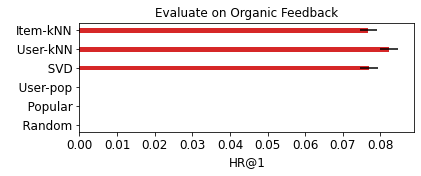

CPU times: user 6min 45s, sys: 43 s, total: 7min 28s
Wall time: 4min 43s


In [ ]:
%%time
result_LOO = verify_agents_traditional(test_log, deepcopy(agents))
display(result_LOO)
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')

#### IPS Estimators

In [ ]:
# Generate new logs, to be used for offline testing
test_log_ppop = env.generate_logs(n_test_users, agent = deepcopy(PPOP_agent))

In [ ]:
test_log_ppop.head()

,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,220,<NA>,NaN,NaN,None
1,1.0,0,organic,867,<NA>,NaN,NaN,None
2,2.0,0,organic,969,<NA>,NaN,NaN,None
3,3.0,0,organic,730,<NA>,NaN,NaN,None
4,4.0,0,bandit,<NA>,969,0.0,0.25,()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars


Effective sample size for agent     Random is 0
Effective sample size for agent    Popular is 0
Effective sample size for agent    User-pop is 0
Effective sample size for agent   SVD is 21243.67667925834
Effective sample size for agent  User-kNN is 33971.880634000554
Effective sample size for agent Item-kNN is 39627.482103973896


,Agent,0.025,0.500,0.975
0,Random,NaN,0.000000,NaN
1,Popular,NaN,0.000000,NaN
2,User-pop,NaN,0.000000,NaN
3,SVD,0.005323,0.013057,0.020791
4,User-kNN,0.010922,0.017513,0.024104
5,Item-kNN,0.012314,0.018250,0.024186


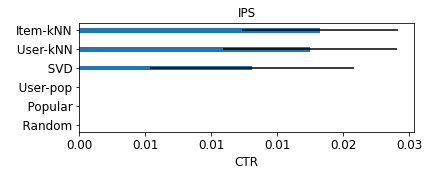

,Agent,0.025,0.500,0.975
0,Random,NaN,0.000000,NaN
1,Popular,NaN,0.000000,NaN
2,User-pop,NaN,0.000000,NaN
3,SVD,0.005590,0.012160,0.018731
4,User-kNN,0.010801,0.016735,0.022670
5,Item-kNN,0.012184,0.017599,0.023014


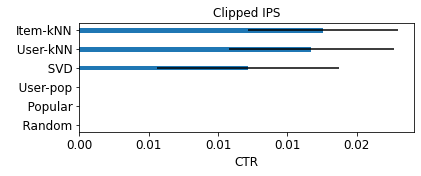

CPU times: user 45min 36s, sys: 2min 15s, total: 47min 51s
Wall time: 29min 38s


In [ ]:
%%time
cap = 15
result_IPS, result_CIPS, result_SNIPS = verify_agents_counterfactual(test_log_ppop, deepcopy(agents), cap = cap)
display(result_IPS)
plot_barchart(result_IPS, 'IPS', 'CTR', 'tab:blue', 'bandit_eval_noclip.eps')
display(result_CIPS)
plot_barchart(result_CIPS, 'Clipped IPS', 'CTR', 'tab:blue', 'bandit_eval_clip{0}.eps'.format(cap))

#### A/B tests

In [ ]:
%%time
result_AB = verify_agents(env, n_test_users, deepcopy(agents))
display(result_AB)
plot_barchart(result_AB, 'A/B-test', 'CTR', 'tab:green', 'ABtest_eval.eps')

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [05:39<00:00, 14.71it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [05:35<00:00, 14.92it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [06:49<00:00, 12.20it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [06:39<00:00, 12.53it/s]
Organic Users: 0it [00:00, ?it/s]
Users:  83%|████████▎ | 4163/5000 [18:04<03:51,  3.62it/s]

In [ ]:
def combine_barchart(resultAB, resultCIPS, title, xlabel,  figname = 'fig.eps', size = (6,2), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(resultAB)
    
    for i, (name, colour, result) in enumerate([('A/B-test', 'tab:green', result_AB),('CIPS', 'tab:blue', result_CIPS)]):
        mean = result['0.500']
        lower = result['0.500'] - result['0.025']
        upper = result['0.975'] - result['0.500']
        height = .25
        yticks = [a + i * height for a in range(n_agents)]
        plt.barh(yticks,
                 mean,
                 height = height,
                 xerr  = (lower, upper),
                 align = 'edge',
                 label = name,
                 color = colour)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.legend(loc = 'lower right')
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()
combine_barchart(result_AB, result_CIPS, 'Evaluate on Bandit Feedback', 'CTR', 'ABtest_CIPS.eps')

In [ ]:
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')

## Recogym small
> Running recogym for offline simulation and evaluation with small number of users and items

### Imports

In [ ]:
!pip install -q recogym

In [ ]:
import numpy as np
from numpy.random.mtrand import RandomState
from scipy.special import logsumexp
import scipy
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from itertools import chain
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, HTML

from matplotlib.ticker import FormatStrFormatter

import gym, recogym
from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents.organic_count import OrganicCount, organic_count_args, to_categorical
from recogym import Configuration
from recogym.agents import Agent
from recogym.envs.observation import Observation
from recogym.agents import RandomAgent, random_args
from recogym import verify_agents, verify_agents_IPS
from recogym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k

from recogym.envs.session import OrganicSessions
from recogym.envs.context import DefaultContext
from recogym.envs.observation import Observation

import matplotlib.pyplot as plt
%matplotlib inline

P = 50 # Number of Products
U = 50 # Number of Users

In [ ]:
# You can overwrite environment arguments here
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P//2
env_1_args['sigma_mu_organic'] = 0.1
env_1_args['sigma_omega']=0.05

In [ ]:
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [ ]:
env.reset()

In [ ]:
# Generate RecSys logs for U users
reco_log = env.generate_logs(U)
reco_log.head(20)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 44.55it/s]


,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,6,<NA>,NaN,NaN,None
1,1.0,0,organic,6,<NA>,NaN,NaN,None
2,2.0,0,organic,31,<NA>,NaN,NaN,None
3,3.0,0,organic,2,<NA>,NaN,NaN,None
4,4.0,0,organic,31,<NA>,NaN,NaN,None
5,5.0,0,organic,32,<NA>,NaN,NaN,None
6,6.0,0,organic,1,<NA>,NaN,NaN,None
7,7.0,0,bandit,<NA>,23,0.0,0.02,()
8,8.0,0,bandit,<NA>,10,0.0,0.02,()
9,9.0,0,bandit,<NA>,34,0.0,0.02,()


In [ ]:
n_events = reco_log.shape[0]
n_organic = reco_log.loc[reco_log['z'] == 'organic'].shape[0]
print('Training on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Training on 1117 organic and 3926 bandit events


### Defining evaluation methods

#### Traditional evaluation

In [ ]:
def leave_one_out(reco_log, agent, last = False, N = 1, folds = 10):
    # 1. Extract all organic events
    reco_log = reco_log.loc[reco_log['z'] == 'organic']
    
    # 2. For every user sequence - randomly sample out an item
    hits = []
    for _ in range(folds):
        user_id = 0
        history = []
        session = OrganicSessions()
        agent.reset()
        for row in reco_log.itertuples():
            # If we have a new user
            if row.u != user_id:
                if last:
                    # Sample out last item
                    index = len(history) - 1
                else:
                    # Sample out a random item from the history
                    index = np.random.choice(len(history),
                                             replace = False)
                test  = history[index]
                train = history[:index] + history[index + 1:]

                # 3. Recreate the user sequence without these items - Let the agent observe the incomplete sequence
                for t, v in list(train):
                    session.next(DefaultContext(t, user_id), int(v))

                # 4. Generate a top-N set of recommendations by letting the agent act
                # TODO - For now only works for N = 1
                try:
                    prob_a = agent.act(Observation(DefaultContext(t + 1, user_id), session), 0, False)['ps-a']
                except:
                    prob_a = [1 / P] * P

                # 5. Compute metrics checking whether the sampled test item is in the top-N
                try:
                  hits.append(np.argmax(prob_a) == int(test[1]))
                except:
                  hits.append(0)

                # Reset variables
                user_id = row.u
                history = []
                session = OrganicSessions()
                agent.reset()

            # Save the organic interaction to the running average for the session
            history.append((row.t,row.v))
    
    # Error analysis
    mean_hits = np.mean(hits)
    serr_hits = np.std(hits) / np.sqrt(len(hits))
    low_bound = mean_hits - 1.96 * serr_hits
    upp_bound = mean_hits + 1.96 * serr_hits
    
    return mean_hits, low_bound, upp_bound

def verify_agents_traditional(reco_log, agents, last = False, N = 1, folds = 10):
    # Placeholder DataFrame for result
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Compute HR@k
        mean, low, upp = leave_one_out(reco_log, agents[agent_id], last = last, N = N, folds = folds)
        stat['Agent'].append(agent_id)
        stat['0.025'].append(low)
        stat['0.500'].append(mean)
        stat['0.975'].append(upp)
    return pd.DataFrame().from_dict(stat)

#### Counterfactual evaluation

In [ ]:
def compute_ips_weights(agent, reco_log):
    # Placeholder for return values
    rewards = [] # Labels for actions
    t_props = [] # Treatment propensities
    l_props = [] # Logging propensities
    
    # For every logged interaction
    user_id = 0
    session = OrganicSessions()
    agent.reset()
    for row in reco_log.itertuples():
        # If we have a new user
        if row.u != user_id:
            # Reset
            session = OrganicSessions()
            agent.reset()
            user_id = row.u
        
        # If we have an organic event
        if row.z == 'organic':
            session.next(DefaultContext(row.t, row.u), int(row.v))        
            
        else:
            prob_a = agent.act(Observation(DefaultContext(row.t, row.u), session), 0, False)['ps-a']
            rewards.append(row.c)
            try:
              t_props.append(prob_a[int(row.a)])
            except:
              t_props.append(0)
            l_props.append(row.ps)
            session = OrganicSessions()
    
    return np.asarray(rewards), np.asarray(t_props), np.asarray(l_props)

def verify_agents_counterfactual(reco_log, agents, cap = 3):
    # Placeholder DataFrame for results
    IPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    CIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    SNIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Get the rewards and propensities
        rewards, t_props, l_props = compute_ips_weights(agents[agent_id], reco_log)
        
        # Compute the sample weights - propensity ratios
        p_ratio = t_props / l_props

        # Effective sample size for E_t estimate (from A. Owen)
        n_e = len(rewards) * (np.mean(p_ratio) ** 2) / (p_ratio ** 2).mean()
        n_e = 0 if np.isnan(n_e) else n_e
        print("Effective sample size for agent {} is {}".format(str(agent_id), n_e))
        
        # Critical value from t-distribution as we have unknown variance
        alpha = .00125
        cv = scipy.stats.t.ppf(1 - alpha, df = int(n_e) - 1)
        
        ###############
        # VANILLA IPS #
        ###############
        # Expected reward for pi_t
        E_t = np.mean(rewards * p_ratio)

        # Variance of the estimate
        var = ((rewards * p_ratio - E_t) ** 2).mean()
        stddev = np.sqrt(var)
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound = E_t - cv * stddev / np.sqrt(int(n_e))
        max_bound = E_t + cv * stddev / np.sqrt(int(n_e))
        
        # Store result
        IPS_stat['Agent'].append(agent_id)
        IPS_stat['0.025'].append(min_bound)
        IPS_stat['0.500'].append(E_t)
        IPS_stat['0.975'].append(max_bound)
        
        ############## 
        # CAPPED IPS #
        ##############
        # Cap ratios
        p_ratio_capped = np.clip(p_ratio, a_min = None, a_max = cap)
        
        # Expected reward for pi_t
        E_t_capped = np.mean(rewards * p_ratio_capped)

        # Variance of the estimate
        var_capped = ((rewards * p_ratio_capped - E_t_capped) ** 2).mean()
        stddev_capped = np.sqrt(var_capped)        
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_capped = E_t_capped - cv * stddev_capped / np.sqrt(int(n_e))
        max_bound_capped = E_t_capped + cv * stddev_capped / np.sqrt(int(n_e))
        
        # Store result
        CIPS_stat['Agent'].append(agent_id)
        CIPS_stat['0.025'].append(min_bound_capped)
        CIPS_stat['0.500'].append(E_t_capped)
        CIPS_stat['0.975'].append(max_bound_capped)
        
        ##############
        # NORMED IPS #
        ##############
        # Expected reward for pi_t
        E_t_normed = np.sum(rewards * p_ratio) / np.sum(p_ratio)

        # Variance of the estimate
        var_normed = np.sum(((rewards - E_t_normed) ** 2) * (p_ratio ** 2)) / (p_ratio.sum() ** 2)    
        stddev_normed = np.sqrt(var_normed)

        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_normed = E_t_normed - cv * stddev_normed / np.sqrt(int(n_e))
        max_bound_normed = E_t_normed + cv * stddev_normed / np.sqrt(int(n_e))

        # Store result
        SNIPS_stat['Agent'].append(agent_id)
        SNIPS_stat['0.025'].append(min_bound_normed)
        SNIPS_stat['0.500'].append(E_t_normed)
        SNIPS_stat['0.975'].append(max_bound_normed)
        
    return pd.DataFrame().from_dict(IPS_stat), pd.DataFrame().from_dict(CIPS_stat), pd.DataFrame().from_dict(SNIPS_stat)

### Creating agents

#### SVD agent

In [ ]:
class SVDAgent(Agent):
    def __init__(self, config, U = U, P = P, K = 5):
        super(SVDAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        assert(P >= K)
        self.K = K
        self.R = csr_matrix((U,P))
        self.V = np.zeros((P,K))
        self.user_history = np.zeros(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Singular Value Decomposition
        _, _, self.V = svds(self.R, k = self.K)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.V.T).dot(self.V)
        action = np.argmax(scores)
        prob = np.zeros_like(scores)
        prob[action] = 1.0

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

#### Item-KNN agent

In [ ]:
class itemkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(itemkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.Rt = csr_matrix((P,U))
        self.user_history = np.zeros(P)
        self.S = np.eye(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R_t = csr_matrix((np.ones(len(reco_log)),
                              (reco_log['v'],reco_log['u'])),
                              (P,U))

        # Set up nearest neighbours module
        nn = NearestNeighbors(n_neighbors = self.k,
                              metric = 'cosine')

        # Initialise placeholder for distances and indices
        distances = []
        indices   = []

        # Dirty fix for multiprocessing backend being unable to pickle large objects
        nn.fit(self.R_t)
        distances, indices = nn.kneighbors(self.R_t, return_distance = True)

        # Precompute similarity matrix S
        data = list(chain.from_iterable(1.0 - distances))
        rows = list(chain.from_iterable([i] * self.k for i in range(P)))
        cols = list(chain.from_iterable(indices))
        
        # (P,P)-matrix with cosine similarities between items
        self.S = csr_matrix((data,(rows, cols)), (P,P)).todense()
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.S).A1
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.S.shape[0], p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

#### User-KNN agent

In [ ]:
class userkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(userkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.U = U
        self.P = P
        self.R = csr_matrix((U,P))
        self.user_history = np.zeros(P)
        self.nn = NearestNeighbors(n_neighbors = self.k, metric = 'cosine')
        
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Fit nearest neighbours
        self.nn.fit(self.R)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        
        # Get neighbouring users based on user history
        distances, indices = self.nn.kneighbors(self.user_history.reshape(1,-1))
        scores = np.add.reduce([dist * self.R[idx,:] for dist, idx in zip(distances,indices)])
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.P, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

#### Agent initializations

In [ ]:
# SVD Agent
SVD_agent = SVDAgent(Configuration(env_1_args), U, P, 30)

# item-kNN Agent
itemkNN_agent = itemkNNAgent(Configuration(env_1_args), U, P, 500, greedy = True)

# user-kNN Agent
userkNN_agent = userkNNAgent(Configuration(env_1_args), U, P, 20, greedy = True)

# Generalised Popularity agent
GPOP_agent = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': True,
}))

# Generalised Popularity agent
GPOP_agent_greedy = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': False,
}))

# Peronalised Popularity agent
PPOP_agent = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': True,
}))

# Peronalised Popularity agent
PPOP_agent_greedy = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': False,
}))

# Random Agent
random_args['num_products'] = P
RAND_agent = RandomAgent(Configuration({**env_1_args, **random_args,}))

In [ ]:
SVD_agent.train(reco_log)
itemkNN_agent.train(reco_log)
userkNN_agent.train(reco_log)

### Offline evaluation

#### Generating test logs

In [ ]:
%%time
# Placeholder for agents
agents = {
    '    Random': RAND_agent,
    '   Popular': GPOP_agent_greedy,
    '   User-pop': PPOP_agent,
    '  SVD':  SVD_agent,
    ' User-kNN': userkNN_agent,
    'Item-kNN': itemkNN_agent,
}
agent_ids = sorted(list(agents.keys()))#['SVD','GPOP','PPOP','RAND']
# Generate new logs, to be used for offline testing
n_test_users = 50 # U
test_log = env.generate_logs(n_test_users)
n_events = test_log.shape[0]
n_organic = test_log.loc[test_log['z'] == 'organic'].shape[0]
print('Testing on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 39.77it/s]

Testing on 1033 organic and 4264 bandit events
CPU times: user 1.29 s, sys: 75.4 ms, total: 1.36 s
Wall time: 1.3 s


#### (Util) helper function to plot barchart

In [ ]:
def plot_barchart(result, title, xlabel,  col = 'tab:red', figname = 'fig.eps', size = (6,2), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(result)
    yticks = np.arange(n_agents)
    mean = result['0.500']
    lower = result['0.500'] - result['0.025']
    upper = result['0.975'] - result['0.500']
    plt.barh(yticks,
             mean,
             height = .25,
             xerr  = (lower, upper),
             align = 'center',
             color = col,)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()

#### Leave-one-out evaluation

/usr/local/lib/python3.7/dist-packages/recogym/agents/organic_user_count.py:51: RuntimeWarning: invalid value encountered in true_divide
  action_proba = features / np.sum(features)


,Agent,0.025,0.500,0.975
0,Random,0.000000,0.000000,0.000000
1,Popular,0.000000,0.000000,0.000000
2,User-pop,0.000000,0.000000,0.000000
3,SVD,0.273181,0.314286,0.355390
4,User-kNN,0.080663,0.108163,0.135664
5,Item-kNN,0.261387,0.302041,0.342695


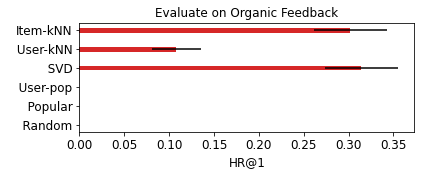

CPU times: user 1.5 s, sys: 61.4 ms, total: 1.56 s
Wall time: 1.53 s


In [ ]:
%%time
result_LOO = verify_agents_traditional(test_log, deepcopy(agents))
display(result_LOO)
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')

#### IPS Estimators

In [ ]:
# Generate new logs, to be used for offline testing
test_log_ppop = env.generate_logs(n_test_users, agent = deepcopy(PPOP_agent))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 27.14it/s]


In [ ]:
test_log_ppop.head()

,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,7,<NA>,NaN,NaN,None
1,1.0,0,organic,9,<NA>,NaN,NaN,None
2,2.0,0,organic,7,<NA>,NaN,NaN,None
3,3.0,0,organic,20,<NA>,NaN,NaN,None
4,4.0,0,bandit,<NA>,20,0.0,0.25,()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars


Effective sample size for agent     Random is 0
Effective sample size for agent    Popular is 0
Effective sample size for agent    User-pop is 0
Effective sample size for agent   SVD is 1120.7440758663975
Effective sample size for agent  User-kNN is 298.0127276763118
Effective sample size for agent Item-kNN is 889.7428242947079


,Agent,0.025,0.500,0.975
0,Random,NaN,0.000000,NaN
1,Popular,NaN,0.000000,NaN
2,User-pop,NaN,0.000000,NaN
3,SVD,-0.010231,0.014218,0.038666
4,User-kNN,-0.024978,0.005388,0.035754
5,Item-kNN,-0.011787,0.011767,0.035322


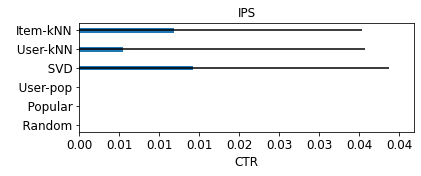

,Agent,0.025,0.500,0.975
0,Random,NaN,0.000000,NaN
1,Popular,NaN,0.000000,NaN
2,User-pop,NaN,0.000000,NaN
3,SVD,-0.010231,0.014218,0.038666
4,User-kNN,-0.024978,0.005388,0.035754
5,Item-kNN,-0.011787,0.011767,0.035322


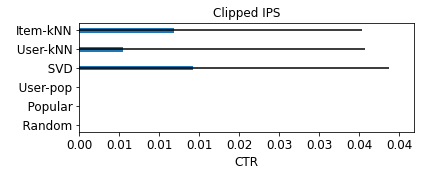

CPU times: user 5.97 s, sys: 120 ms, total: 6.09 s
Wall time: 6.03 s


In [ ]:
%%time
cap = 15
result_IPS, result_CIPS, result_SNIPS = verify_agents_counterfactual(test_log_ppop, deepcopy(agents), cap = cap)
display(result_IPS)
plot_barchart(result_IPS, 'IPS', 'CTR', 'tab:blue', 'bandit_eval_noclip.eps')
display(result_CIPS)
plot_barchart(result_CIPS, 'Clipped IPS', 'CTR', 'tab:blue', 'bandit_eval_clip{0}.eps'.format(cap))

#### A/B tests

In [ ]:
n_test_users = 50 # U

agents = {
    '    Random': RAND_agent,
    '   Popular': GPOP_agent_greedy,
    '   User-pop': PPOP_agent,
    '  SVD':  SVD_agent,
    ' User-kNN': userkNN_agent,
    'Item-kNN': itemkNN_agent,
}

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 36.23it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 41.71it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 28.04it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 35.95it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 33.91it/s]


,Agent,0.025,0.500,0.975
0,Random,0.007624,0.010324,0.013590
1,Popular,0.008203,0.010997,0.014357
2,User-pop,0.011879,0.015227,0.019140
3,SVD,0.012572,0.015994,0.019976
4,User-kNN,0.011999,0.015350,0.019263
5,Item-kNN,0.012174,0.015545,0.019477


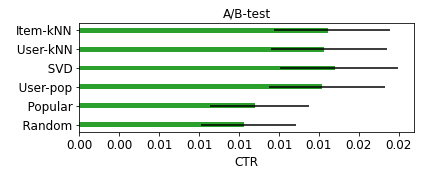

CPU times: user 14 s, sys: 445 ms, total: 14.4 s
Wall time: 14.1 s


In [ ]:
%%time
result_AB = verify_agents(env, n_test_users, deepcopy(agents))
display(result_AB)
plot_barchart(result_AB, 'A/B-test', 'CTR', 'tab:green', 'ABtest_eval.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


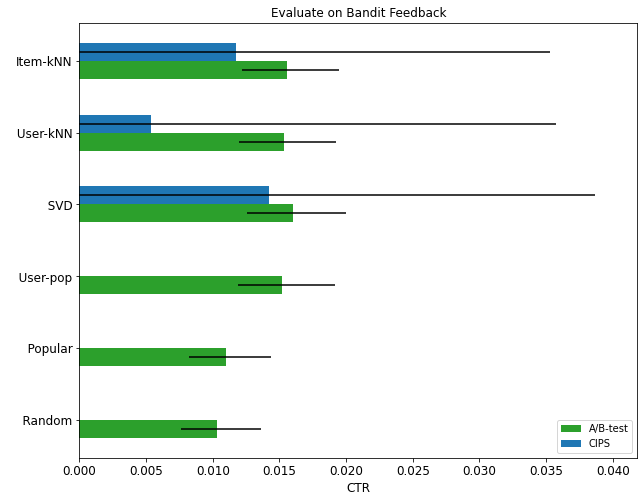

In [ ]:
def combine_barchart(resultAB, resultCIPS, title, xlabel,  figname = 'fig.eps', size = (10,8), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(resultAB)
    
    for i, (name, colour, result) in enumerate([('A/B-test', 'tab:green', result_AB),('CIPS', 'tab:blue', result_CIPS)]):
        mean = result['0.500']
        lower = result['0.500'] - result['0.025']
        upper = result['0.975'] - result['0.500']
        height = .25
        yticks = [a + i * height for a in range(n_agents)]
        plt.barh(yticks,
                 mean,
                 height = height,
                 xerr  = (lower, upper),
                 align = 'edge',
                 label = name,
                 color = colour)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.legend(loc = 'lower right')
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()
combine_barchart(result_AB, result_CIPS, 'Evaluate on Bandit Feedback', 'CTR', 'ABtest_CIPS.eps')

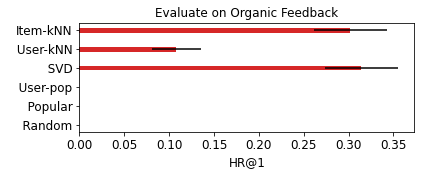

In [ ]:
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')

## Amazon electronics dataset
> Running bandit models on amazon electronics ratings dataset for offline evaluation

### Libraries

In [ ]:
import os
import sys
import time
import json
import datetime
import logging
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Data

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d saurav9786/amazon-product-reviews

In [ ]:
!unzip amazon-product-reviews.zip

Archive:  amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


### Utils

In [ ]:
# getting the current system time
current_time = datetime.datetime.now().strftime("%Y-%m-%d__%H.%M")

# run folder which will be unique always
run_folder = str(datetime.datetime.now())

# temprary folder location to export the results
temp_folder = "./output/"

# target folder to export all the result
target_dir = temp_folder + '/' + run_folder

# checking if the temp folder exists. Create one if not
check_folder = os.path.isdir(target_dir)
if not check_folder:
    os.makedirs(target_dir)
    print("created folder : ", target_dir)

# latency dictionary to hold execution time
latency = dict()

# removing any existing log files if present
if os.path.exists(target_dir + '/main.log'):
    os.remove(target_dir+ '/main.log')

created folder :  ./output//2021-06-16 21:35:53.937354


In [ ]:
def get_loggers(temp_path):
  # name the logger as HPC-AI skunkworks
  logger = logging.getLogger("Multi-Arm-Bandit")
  logger.setLevel(logging.INFO)
  # file where the custom logs needs to be handled
  f_hand = logging.FileHandler(temp_path + '/.log')
  f_hand.setLevel(logging.INFO)  # level to set for logging the errors
  f_format = logging.Formatter('%(asctime)s : %(levelname)s : %(message)s',
                                datefmt='%d-%b-%y %H:%M:%S')
  # format in which the logs needs to be written
  f_hand.setFormatter(f_format)  # setting the format of the logs
  # setting the logging handler with the above formatter specification
  logger.addHandler(f_hand)

  stdout_handler = logging.StreamHandler()
  stdout_handler.setFormatter(f_format)
  logger.addHandler(stdout_handler)

  return logger

In [ ]:
# get custom logger
logger = get_loggers(target_dir)

In [ ]:
def export_to_json(dictionary, file_name):
  try:
    start = time.time()
    json_data = json.dumps(dictionary, indent=4)
    file = open(file_name, 'w')
    print(json_data, file=file)
    # updating into json
    file.close()
    stop = time.time()
    latency['export_to_json_'] = stop - start
    logger.info('Data exported to JSON successfully!')
  except Exception as e:
    logger.exception(e)
    sys.exit(1)

### Defining agents

In [ ]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

This script is used for simulating AB testing simulator

'''

import numpy as np
from tqdm import tqdm


class ABTestReplayer():
    '''
    A class to provide functionality for simulating the method on an A/B test.
    '''
    
    def __init__(self, n_visits, n_test_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations

        
        # TODO: validate that n_test_visits <= n_visits
    
        self.n_test_visits = n_test_visits

        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None
        
    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
        self.is_testing = True
        self.best_item_idx = None
    
    def select_item(self):
        if self.is_testing:
            return np.random.randint(self.n_items)
        else:
            return self.best_item_idx
            
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]

        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])
        
        if (visit == self.n_test_visits - 1): # this was the last visit during the testing phase
            
            self.is_testing = False
            self.best_item_idx = np.argmax(self.n_item_rewards)

    def simulator(self):
    
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''

import numpy as np
from tqdm import tqdm

class EpsilonGreedyReplayer():
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon

        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = np.random.randint(self.n_items)
            
        else: # exploit
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id
    
    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)

    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

    
    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''

import numpy as np
from tqdm import tqdm

class ThompsonSamplingReplayer():
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm

    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations
    


        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None

    def reset(self):
        self.alphas = np.ones(self.n_items)
        self.betas = np.ones(self.n_items)

    def select_item(self):
    
        samples = [np.random.beta(a,b) for a,b in zip(self.alphas, self.betas)]
        
        return np.argmax(samples)

    def record_result(self, visit, item_idx, reward):
        
        # update value estimate
        if reward == 1:
            self.alphas[item_idx] += 1
        else:
            self.betas[item_idx] += 1



    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''
import numpy as np
from tqdm import tqdm


class ReplaySimulator(object):
    '''
    A class to provide base functionality for simulating the replayer method for online algorithms.
    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):

        np.random.seed(random_seed)
    
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of visits to replay/simulate
        self.n_visits = n_visits
        
        # number of runs to average over
        self.n_iterations = n_iterations
    
        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        

    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
    
    def replay(self):
        
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                ## record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results
        
    def select_item(self):
        return np.random.randint(self.n_items)
        
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

In [ ]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''

import numpy as np
from tqdm import tqdm

class UCBSamplingReplayer():
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm

    '''

    def __init__(self,ucb_c, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.ucb_c = ucb_c

        # number of runs to average over
        self.n_iterations = n_iterations
    


        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None

    def reset(self):
        self.Q = np.zeros(self.n_items) # q-value of actions
        self.N = np.zeros(self.n_items) + 0.0001 # action count
        self.timestep = 1


    def select_item(self):

        ln_timestep = np.log(np.full(self.n_items, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)

        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        
        return action

    def record_result(self, visit, item_idx, reward):
        
        # update value estimate
        self.N[item_idx] += 1 # increment action count
        self.Q[item_idx] += 1/self.N[item_idx] * (reward - self.Q[item_idx]) # inc. update rule


    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

### Running simulation

In [ ]:
logger.info("Multi-Armed-Bandits-for-Recommendations-and-A-B-testing !!!")
logger.info("Current time: " + str(current_time))

logger.info("Reading the data..!!")

start = time.time()
header_list = ["User_ID", "Product_ID", "Rating", "Time_Stamp"]
rating_df = pd.read_csv('ratings_Electronics (1).csv', names=header_list)
latency["Data_reading -"] = time.time() - start
logger.info("Read the data Successfully ..!!!")

reward_threshold = 4
rating_df['reward'] = rating_df.eval('Rating > @reward_threshold').astype(int)

16-Jun-21 22:00:41 : INFO : Multi-Armed-Bandits-for-Recommendations-and-A-B-testing !!!
16-Jun-21 22:00:41 : INFO : Current time: 2021-06-16__21.35
16-Jun-21 22:00:41 : INFO : Reading the data..!!
16-Jun-21 22:00:47 : INFO : Read the data Successfully ..!!!


In [ ]:
n_visits = 500
n_iterations = 1
n_test_visits = 100

reward_history = rating_df[:1000]
item_col_name = 'Product_ID'
visitor_col_name = 'User_ID'
reward_col_name = 'reward'

In [ ]:
#################### A/B testing ###############

logger.info("A/B Test Simulations...starts...!!!")

start = time.time()
ab_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                            item_col_name, visitor_col_name, reward_col_name,
                            n_iterations=n_iterations).simulator()

ab_results_df = pd.DataFrame(ab_results)
latency["A/B testing -"] = time.time() - start

logger.info("A/B testing completed Successfully..!!")

ab_results_df.to_csv(target_dir + '/ab_results_df.csv')

logger.info("Saving the A/B test results saved Successfully..!!")

16-Jun-21 22:01:52 : INFO : A/B Test Simulations...starts...!!!

100%|██████████| 1/1 [03:07<00:00, 187.56s/it]
16-Jun-21 22:04:59 : INFO : A/B testing completed Successfully..!!
16-Jun-21 22:04:59 : INFO : Saving the A/B test results saved Successfully..!!


In [ ]:
################# Epsilon - Greedy Simulations ##############

logger.info("Epsilon - Greedy Simulations...starts...!!!")

start = time.time()
epsilon = 0.05
epsilon_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                        item_col_name, visitor_col_name, reward_col_name,
                                        n_iterations=n_iterations).simulator()

epsilon_results_df = pd.DataFrame(epsilon_results)
latency["Epsilon - Greedy Simulations  -"] = time.time() - start
logger.info("Epsilon - Greedy Simulations completed Successfully..!!")

epsilon_results_df.to_csv(target_dir +'/epsilon_results_df.csv')

logger.info("Epsilon - Greedy Simulations results saved Successfully..!!")

16-Jun-21 22:04:59 : INFO : Epsilon - Greedy Simulations...starts...!!!

100%|██████████| 1/1 [10:38<00:00, 638.64s/it]
16-Jun-21 22:15:38 : INFO : Epsilon - Greedy Simulations completed Successfully..!!
16-Jun-21 22:15:38 : INFO : Epsilon - Greedy Simulations results saved Successfully..!!


In [ ]:
################### Thompson Sampling Simulations #######################

logger.info("Thompson Sampling Simulations...starts...!!!")

start = time.time()

thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).simulator()

thompson_results_df = pd.DataFrame(thompson_results)
latency["Thompson Sampling Simulations  -"] = time.time() - start
logger.info("Thompson Sampling Simulations completed Successfully..!!")

thompson_results_df.to_csv(target_dir +'/thompson_results_df.csv')

logger.info("Thompson Sampling Simulations results saved Successfully..!!")

16-Jun-21 22:15:38 : INFO : Thompson Sampling Simulations...starts...!!!

100%|██████████| 1/1 [11:51<00:00, 711.80s/it]
16-Jun-21 22:27:30 : INFO : Thompson Sampling Simulations completed Successfully..!!
16-Jun-21 22:27:30 : INFO : Thompson Sampling Simulations results saved Successfully..!!


In [ ]:
####################  Upper Confidence Bounds #########################

logger.info("Upper Confidence Bounds Simulations...starts...!!!")

start = time.time()

ucb = 2

ucb_results = UCBSamplingReplayer(ucb, n_visits, reward_history,
                                  item_col_name, visitor_col_name, reward_col_name,
                                  n_iterations=n_iterations).simulator()

ucb_results_df = pd.DataFrame(ucb_results)
latency["Upper Confidence Bounds Simulations  -"] = time.time() - start

logger.info("Upper Confidence Bounds Simulations completed Successfully..!!")

ucb_results_df.to_csv(target_dir +'/ucb_results_df.csv')

logger.info("Upper Confidence Bounds Simulations results saved Successfully..!!")

logger.info('Exporting the latency')
file_name = target_dir +'/latency_stats.json'
export_to_json(latency, file_name)
logger.info("Program completed normally")
logger.handlers.clear()

16-Jun-21 22:27:30 : INFO : Upper Confidence Bounds Simulations...starts...!!!

100%|██████████| 1/1 [14:35<00:00, 875.29s/it]
16-Jun-21 22:42:05 : INFO : Upper Confidence Bounds Simulations completed Successfully..!!
16-Jun-21 22:42:05 : INFO : Upper Confidence Bounds Simulations results saved Successfully..!!
16-Jun-21 22:42:05 : INFO : Exporting the latency
16-Jun-21 22:42:05 : INFO : Data exported to JSON successfully!
16-Jun-21 22:42:05 : INFO : Program completed normally


### Result analysis

In [ ]:
'''
The Csv files present in current 
output run directory are Read 
for all the algos

'''

ucb_results_df = pd.read_csv(os.path.join(target_dir,'ucb_results_df.csv')).drop('Unnamed: 0', axis=1)
thompson_results_df = pd.read_csv(os.path.join(target_dir,'thompson_results_df.csv')).drop('Unnamed: 0', axis=1)
epsilon_results_df = pd.read_csv(os.path.join(target_dir,'epsilon_results_df.csv')).drop('Unnamed: 0', axis=1)
ab_results_df = pd.read_csv(os.path.join(target_dir,'ab_results_df.csv')).drop('Unnamed: 0', axis=1)

In [ ]:
'''
Grouping the each data frame with visit with mean
'''

ucb_avg_results_df = ucb_results_df.groupby('visit', as_index=False).mean()

thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()

epsilon_avg_results_df = epsilon_results_df.groupby('visit', as_index=False).mean()

ab_avg_results_df = ab_results_df.groupby('visit', as_index=False).mean()

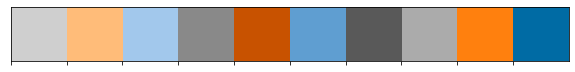

In [ ]:
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

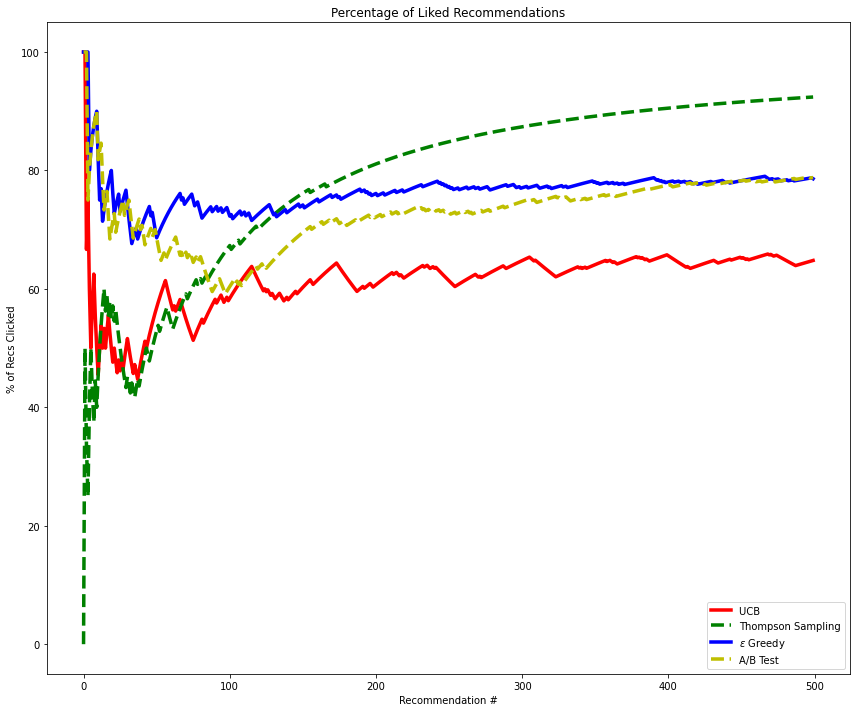

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_df, style) in [(ucb_avg_results_df, 'r-'),
                                (thompson_avg_results_df, 'g--'),
                                (epsilon_avg_results_df, 'b-'),
                                (ab_avg_results_df, 'y--')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)


ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Clicked')

#ax.set_xticks(range(0,22000,5000))
#ax.set_ylim(0.2, 0.6)
#ax.set_yticks(np.arange(0.2, 0.7, 0.1))

#rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['UCB ',
           'Thompson Sampling',
           '$\epsilon$ Greedy',
           'A/B Test'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

From the above it is clear that Thompson smapling of multi arm bandit outperforms A/B testing. In the lower samples the Epsilon Greedy better than all other algorithim, but as in when the number smaples increase the thompsonsampling starts performing beter and better.

## Movielens
> Evaluating bandits offline with replay method on movielens dataset

### Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from tqdm import tqdm

from scipy.stats import norm, beta
from abc import ABC, abstractmethod

### Loading data

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

rating_df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'], usecols=['movie_id', 'rating'])
rating_df.columns = ['movieId', 'rating']
rating_df.head()

### Util functions

In [ ]:
def get_data(data, num_ratings, num_movies):
    """ Make each movieId/action uniformly distributed """
    # filters out movies with less than `num_ratings` ratings
    movies = data.groupby('movieId').agg({'rating': 'count'})
    if num_movies is not None:
        movies_to_keep = movies[(movies['rating'] >= num_ratings)].sample(
            n=num_movies, random_state=12).index
    else:
        movies_to_keep = movies[(movies['rating'] >= num_ratings)].index
    data = data[data['movieId'].isin(movies_to_keep)]
    # take a random sample of size `num_ratings` for each movie
    data = data.groupby('movieId').sample(n=num_ratings, random_state=42)
    # shuffle rows to randomize data stream
    data = data.sample(frac=1, random_state=42)
    # reset index to create pseudo-timestamp index
    data = data.reset_index(drop=True)
    return data


# Plot ################################################################

def plot_rewards(*policies, title=None):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    fig.suptitle(title)
    for policy in policies:
        # get cumulative rewards
        cumsum_rewards = policy.history.reward.cumsum()
        # get average rewards
        timesteps = np.arange(len(cumsum_rewards)) + 1
        avg_rewards = cumsum_rewards / timesteps
        # plots
        ax1.plot(timesteps, avg_rewards, label=policy.name)
        ax2.plot(timesteps, cumsum_rewards, label=policy.name)
    #
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.set_xlabel('time step')
    ax1.set_ylabel('average reward')
    ax1.legend(loc='lower right')
    #
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax2.set_xlabel('time step')
    ax2.set_ylabel('cumulative reward')
    ax2.legend(loc='lower right')
    #
    plt.tight_layout()
    plt.show()


def plot_action_values(*policies):
    fig, axs = plt.subplots(nrows=1, ncols=len(policies), figsize=(15,5), squeeze=False)
    fig.suptitle("Action scores")
    axs = axs.ravel()
    for i, policy in enumerate(policies):
        cbar = True if i == len(axs)-1 else False
        sns.heatmap(policy.scores_log.T, ax=axs[i], vmin=2.5, vmax=5, cmap='hot',
                    cbar=cbar, xticklabels=1000, yticklabels=False)
        axs[i].set_xlabel('time step')
        axs[i].title.set_text(policy.name)
    axs[0].set_ylabel('movieId')
    plt.tight_layout()
    plt.show()

### Set variables

In [ ]:
NUM_RATINGS = 30        # with full dataset  -> 10000
                        # with small dataset -> 30
NUM_MOVIES = None
SLATE_SIZE = 5
BATCH_SIZE = 100        # with replay eval   -> 100
                        # with simulated env -> 1
STREAM_LENGTH = 150     # with full dataset  -> 50000
                        # with small dataset -> 150
MODE = 'replay'         # 'replay' or 'sim'
SCORES_LOG = False      # logging movie scores or not

In [ ]:
# get data
logged_events = get_data(rating_df, NUM_RATINGS, NUM_MOVIES)

### Create agents

In [ ]:
# Abstract Base Policy ###############################################

class ABPolicy(ABC):
    def __init__(self, bandit, slate_size, scores_logging):
        self.name = None
        self.slate_size = slate_size
        self.history = pd.DataFrame(data=None, columns=['movieId', 'reward'])
        if scores_logging is True:
            self.scores_log = pd.DataFrame(data=None, columns=bandit.actions)
        else:
            self.scores_log = None

    @abstractmethod
    def get_recommendations(self):
        ...

    def update(self, rewards):
        # append new events to history
        self.history = self.history.append(rewards, ignore_index=True)
    
    def _sort_actions(self, scores):
        """ Sort actions by score and shuffle actions with same score
            Inputs:
                scores: pandas.Series with actions as index """
        sorted_actions = sorted(
            scores.sample(frac=1).index,
            key=lambda idx: scores.loc[idx],
            reverse=True)
        return sorted_actions

    def _update_scores_history(self, scores):
        if self.scores_log is not None:
            self.scores_log = self.scores_log.append(
                pd.DataFrame(
                    data=scores.to_numpy().reshape((1,-1)),
                    columns=self.scores_log.columns),
                ignore_index=True)
            self.scores_log = self.scores_log.astype('float')



# Epsilon Greedy Policy ##############################################

class EpsilonGreedy(ABPolicy):
    def __init__(self, bandit, epsilon, slate_size=1, scores_logging=False):
        super(EpsilonGreedy, self).__init__(bandit, slate_size, scores_logging)
        self.name = '{}-Greedy'.format(epsilon)
        self.epsilon = epsilon
        self.action_values = pd.DataFrame(data=0, columns=['value', 'count'],
                                          index=bandit.actions)

    def get_recommendations(self):
        # sort actions by value and shuffle actions with same value
        sorted_actions = self._sort_actions(self.action_values['value'])
        # choose recommendations
        if np.random.random() < self.epsilon:
            recs = np.random.choice(sorted_actions[self.slate_size:],
                                    size=self.slate_size, replace=False)
        else:
            recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(self.action_values['value'])
        return recs

    def update(self, rewards):
        super(EpsilonGreedy, self).update(rewards)
        # update action values
        for _, (movieId, reward) in rewards.iterrows():
            value = self.action_values.loc[movieId, 'value']
            N = self.action_values.loc[movieId, 'count']
            self.action_values.loc[movieId, 'value'] = (value * N + reward) / (N + 1)
            self.action_values.loc[movieId, 'count'] += 1
    

# Upper Confidence Bound Policy ######################################

class UCB1(ABPolicy):
    def __init__(self, bandit, slate_size=1, scores_logging=False):
        super(UCB1, self).__init__(bandit, slate_size, scores_logging)
        self.name = 'UCB1'
        self.action_values = pd.DataFrame(data=0, columns=['value', 'count'],
                                          index=bandit.actions)

    def get_recommendations(self):
        # compute UCB for each action
        current_step = len(self.history)
        if current_step > 0:
            scores = self.action_values['count'].apply(
                lambda N: np.sqrt(2*np.log(current_step) / N) if N > 0 else np.Inf)
            scores = scores + self.action_values['value']
        else:
            scores = pd.Series(data=np.Inf, index=self.action_values.index)
        # sort actions by score and shuffle actions with same score
        sorted_actions = self._sort_actions(scores)
        # choose recommendations
        recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(scores)
        return recs

    def update(self, rewards):
        super(UCB1, self).update(rewards)
        # update action values
        for _, (movieId, reward) in rewards.iterrows():
            value = self.action_values.loc[movieId, 'value']
            N = self.action_values.loc[movieId, 'count']
            self.action_values.loc[movieId, 'value'] = (value * N + reward) / (N + 1)
            self.action_values.loc[movieId, 'count'] += 1


# Thompson Sampling Policy ###########################################

class TS(ABPolicy):
    def __init__(self, bandit, slate_size=1, scores_logging=False):
        super(TS, self).__init__(bandit, slate_size, scores_logging)
        self.name = 'Thompson Sampling'
        self.beta_params = pd.DataFrame(data=1, columns=['alpha', 'beta'],
                                        index=bandit.actions)
    
    def get_recommendations(self):
        # sample expected value for each action
        expected_values = pd.Series(
            data=4.5 * beta.rvs(self.beta_params['alpha'], self.beta_params['beta']) + 0.5,
            index=self.beta_params.index)
        # sort actions by value and shuffle actions with same value
        sorted_actions = self._sort_actions(expected_values)
        # choose recommendations
        recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(expected_values)
        return recs

    def update(self, rewards):
        super(TS, self).update(rewards)
        # update action value distribution prior
        for _, (movieId, reward) in rewards.iterrows():
            self.beta_params.loc[movieId, 'alpha'] += (reward - 0.5) / 4.5
            self.beta_params.loc[movieId, 'beta'] += (5.0 - reward) / 4.5

In [ ]:
class ReplayBandit():
    """ Implementation of a bandit problem with replay evaluation """
    def __init__(self, logged_events, batch_size=1):
        self.events = logged_events.rename(columns={'rating': 'reward'})
        self.actions = np.sort(logged_events['movieId'].unique())
        self.batch_size = batch_size
        self.stream_length = len(self.events) // batch_size
    
    def get_rewards(self, recommendations, n_event):
        # generate events
        idx = n_event * self.batch_size
        events =  self.events.iloc[idx:idx+self.batch_size]
        # keep only events that match with the recommendation slate
        rewards = events[events['movieId'].isin(recommendations)]
        return rewards

In [ ]:
bandit = ReplayBandit(logged_events, BATCH_SIZE)
STREAM_LENGTH = bandit.stream_length
title="rewards for bandit problem with replay evaluation"

print("NUMBER OF MOVIES/ACTIONS: {}".format(len(bandit.actions)))

NUMBER OF MOVIES/ACTIONS: 806


In [ ]:
# instantiate policies
policies = [
    EpsilonGreedy(bandit, epsilon=0.1, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    UCB1(bandit, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    TS(bandit, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    ]

In [ ]:
# evaluate policies
for policy in policies:
    print("POLICY: {}".format(policy.name))
    for i in tqdm(range(STREAM_LENGTH), ascii=True):
        recs = policy.get_recommendations()
        rewards = bandit.get_rewards(recs, i)
        policy.update(rewards)
    print("HISTORY LENGTH: {}".format(len(policy.history)))
    print()

  4%|3         | 9/241 [00:00<00:02, 85.23it/s]

POLICY: 0.1-Greedy


  4%|3         | 9/241 [00:00<00:02, 82.17it/s]

HISTORY LENGTH: 133

POLICY: UCB1


  3%|3         | 8/241 [00:00<00:02, 78.25it/s]

HISTORY LENGTH: 144

POLICY: Thompson Sampling


100%|##########| 241/241 [00:03<00:00, 78.49it/s]

HISTORY LENGTH: 141



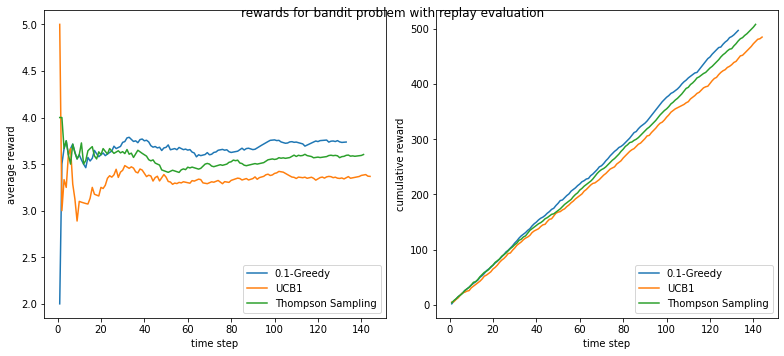

In [ ]:
# plot results
plot_rewards(*policies, title=title)
if SCORES_LOG is True:
    plot_action_values(*policies)